In [1]:
import numpy as np
from setproctitle import setproctitle
setproctitle('notebook@linian')
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import random
from multiprocessing import Pool
from time import time
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import os
import re
from pandarallel import pandarallel
from copy import copy

In [2]:
path = '../data/BeiBei2/'
records = pd.concat([pd.read_csv(path+file) for file in os.listdir(path) if 'non' in file and 'add' not in file])
share = pd.concat([pd.read_csv(path+file) for file in os.listdir(path) if 'ref' in file and 'non' not in file and 'add' not in file])

records_add = pd.read_csv(path+'nonref_add.csv')
records_add['info'] = records_add['info'].apply(lambda x: eval(x))
records_add = records_add.explode('info')
records_add.rename(columns={'info':'iid'}, inplace=True)
records = pd.concat([records, records_add])
records = records.dropna(axis=0,how='any')
records = records.astype('int32')

share_add = pd.read_csv(path+'ref_add.csv')
share_add['info'] = share_add['info'].apply(lambda x: eval(x))
share_add = share_add.explode('info')
share_add[['ruid', 'iid', 'indicators']] = pd.DataFrame(share_add['info'].tolist(), index=share_add.index)   
share_add = share_add.drop(columns=['info'])
share_add = share_add[share_add['ruid'].str.contains('^[0-9]+$', regex=True)]
share = pd.concat([share, share_add])
share = share.dropna(axis=0,how='any')
share = share.astype('int32')

In [4]:
print(len(records), len(share), len(share[share['indicators']==1]))

1408060 1699939 161808


In [37]:
def df_unique(df):
    s = set()
    for d in df:
        s = s.union(set(np.unique(np.array(df, dtype=np.int32)).tolist()))
    return s
tmp_records, tmp_share = copy(records), copy(share)
pandarallel.initialize(nb_workers=16)
for k in range(4):
    records_u, share_u = df_unique([tmp_records['uid']]), df_unique([tmp_share['uid'], tmp_share['ruid']])
    records_i, share_i = df_unique([tmp_records['iid']]), df_unique([tmp_share['iid']])
    U = records_u.intersection(share_u)
    I = records_i.intersection(share_i)
    print(len(U), len(I))
    tmp_records = tmp_records[tmp_records.parallel_apply(lambda row: True if row['uid'] in U and row['iid'] in I else False, axis=1)]
    tmp_share = tmp_share[tmp_share.parallel_apply(lambda row: True if row['uid'] in U and row['ruid'] in U and row['iid'] in I else False, axis=1)]
    print(len(tmp_records), len(tmp_share))
    if k < 3:
        tmp_share = tmp_share.sample(frac=0.5, random_state=123)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
52428 40452
1068610 1410463
39395 32512
902689 704921
33059 26434
792161 352115
27031 20206
670014 175790


In [4]:
uf_u = np.unique(np.array(share[['uid']], dtype=np.int32))
uf_f = np.unique(np.array(share[['ruid']], dtype=np.int32))
uf = np.unique(np.concatenate([uf_u, uf_f], 0))
i = np.unique(np.array(share[['iid']], dtype=np.int32))
u = np.unique(np.array(records[['uid']], dtype=np.int32))
I = np.unique(np.array(records[['iid']], dtype=np.int32))
print(len(u), len(uf), len(np.unique(np.concatenate([uf, u], 0))))
print(len(I), len(i), len(np.unique(np.concatenate([I, i], 0))))

88002 97459 133033
45586 41008 46142


In [5]:
share_buy = share[share['indicators']==1]
buy_u = np.unique(np.array(share_buy[['uid']], dtype=np.int32))
buy_f = np.unique(np.array(share_buy[['ruid']], dtype=np.int32))
buy_uf = np.unique(np.concatenate([buy_u, buy_f], 0))
buy_i = np.unique(np.array(share_buy[['iid']], dtype=np.int32))
print(len(u), len(buy_u), len(np.unique(np.concatenate([buy_u, u], 0))))
print(len(u), len(buy_f), len(np.unique(np.concatenate([buy_f, u], 0))))
print(len(u), len(buy_uf), len(np.unique(np.concatenate([buy_uf, u], 0))))
print(len(I), len(buy_i), len(np.unique(np.concatenate([I, buy_i], 0))))

88002 22021 89069
88002 22051 96409
88002 32476 97250
45586 21860 45683


In [63]:
print(len(u), len(uf_u), len(np.unique(np.concatenate([uf_u, u], 0))))
print(len(u), len(uf_f), len(np.unique(np.concatenate([uf_f, u], 0))))

88002 53126 90110
88002 78848 132075


In [7]:
def filter_fun(row):
    if row['uid'] in buy_uf and row['iid'] in buy_i:
        return True
    else:
        return False
pandarallel.initialize(nb_workers=8)
len(records[records.parallel_apply(filter_fun, axis=1)])

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


558647

In [2]:
import sys 
sys.path.append("..") 
from compute_metric import compute_metric
import torch

In [8]:
scores = torch.Tensor([[1.2, -0.1, 0.5, 0.6], [0.2, -0.1, -0.5, 0.6]])
ground_truth = torch.Tensor([[1, 0, 1, 0], [1, 0, 0, 0]])
class conf_class:
    topk = [2]
conf = conf_class
compute_metric(scores, ground_truth, conf)

{'Recall': [0.74999999625],
 'NDCG': [0.6220384805094975],
 'MRR': [0.74999999625]}

In [3]:
pre_emb = np.load('../embedding/BeiBei/BeiBei_bpr_reg0.01_lr0.001_epoch0+1000_dim64_fs-neg10.ckpt.npz', encoding='latin1')
user_embedding, item_embedding = pre_emb['user_embedding'], pre_emb['item_embedding']

In [6]:
np.linalg.norm(user_embedding[:3], axis=-1)

array([2.9690592, 2.640359 , 2.6007133], dtype=float32)

In [10]:
scores = user_embedding[:4096]@item_embedding.transpose()

In [11]:
scores[:3, :3]

array([[-0.42529726,  1.2020683 , -1.1787714 ],
       [-0.65158635, -0.23876396, -0.07779285],
       [-1.2142563 ,  0.50756305, -1.5263298 ]], dtype=float32)

# Find 3-cliques
- Yelp: ~2900; Ciao: ~1200; Epinions: 1100

In [2]:
data_name = 'BeiBei'
train_path = '../data/{0}/{0}.train.rating'.format(data_name)
social_path = '../data/{0}/{0}_all.links'.format(data_name)
# edge_list = []
train_dict, friend_dict, item_dict = defaultdict(set), defaultdict(set), defaultdict(set)
positive_data, positive_link = [], []
with open(train_path) as f:
    for x in f.readlines():
        u, i = x.rstrip('\n').split('\t')[:2]
        u, i = int(u), int(i)
        positive_data.append([u, i])
        train_dict[u].add(i)
        item_dict[i].add(u)
positive_data = np.array(positive_data)
#         edge_list.append(('u'+str(u), 'i'+str(i)))
with open(social_path) as f:
    for x in f.readlines():
        u, f = x.rstrip('\n').split('\t')[:2]
        u, f = int(u), int(f)
        friend_dict[u].add(f)
        friend_dict[f].add(u)
        positive_link.append([u, f])
positive_link = np.array(positive_link)
positive_link = np.unique(np.concatenate([positive_link, np.fliplr(positive_link)], 0), axis=0)
#         edge_list.append(('u'+str(u), 'u'+str(f)))
# print(len(edge_list))

In [3]:
ufi = []
for u, f in positive_link:
    for i in train_dict[u].intersection(train_dict[f]):
        ufi.append((u, f, i))
# for u in friend_dict:
#     friend = np.array(list(friend_dict[u]))
#     tmp = [len(train_dict[u].intersection(train_dict[f])) for f in friend if len(train_dict[u].intersection(train_dict[f])) > 0]
#     if len(tmp) > 10:
#         tmp_idx = np.argsort(tmp)[-10:]
#         friend = friend[tmp_idx]
#     for f in friend:
#         for i in train_dict[u].intersection(train_dict[f]):
#             ufi.append((u, f, i))
with open('../data/{0}/{0}_ufi.links'.format(data_name), 'w') as file:
    for u, f, i in ufi:
        file.write(f'{u}\t{f}\t{i}\n')

In [11]:
x = np.zeros([5, 1])
np.tile(np.expand_dims(x, 0), [2, 1, 1]).shape

(2, 5, 1)

In [4]:
val_len, biased_len = 0, 0
with open('../data/{0}/{0}.val.rating'.format(data_name)) as f:
    for x in f.readlines():
        u, i = x.rstrip('\n').split('\t')[:2]
        u, i = int(u), int(i)
        if len(friend_dict[u]) > 0:
            biased_len += 1
        val_len += 1
print(val_len, biased_len, 1.0*biased_len/val_len)

71285 60699 0.8514975099950901


In [6]:
biased_len = 0
for u in friend_dict:
    if len(friend_dict[u]) > 0:
        biased_len += 1
print(biased_len*1.0/30887)

0.7419626380030434


In [ ]:
num_friend = []
for u in friend_dict:
    num_friend.append(len(friend_dict[u]))

(array([6492., 3390., 4316., 6324., 1293.,  885.,  137.]),
 array([  0,   3,   5,  10,  50, 100, 300, 500]),
 <a list of 1 Patch objects>)

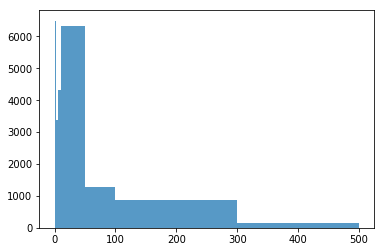

In [72]:
plt.hist(num_friend, [0, 3, 5, 10, 50, 100, 300, 500], histtype='stepfilled', alpha=0.75)

In [4]:
G = nx.Graph()
G.add_edges_from(edge_list)
# cliques = nx.find_cliques(G)

In [59]:
import itertools
cliques3 = set(sum([list(itertools.combinations(set(clq), 3)) for clq in cliques if len(clq)>=3],[]))
print(len(cliques3))

1142


# Find 2-path

In [4]:
candidate_item = defaultdict(set)
for u in train_dict.keys():
    candidate_item[u] = candidate_item[u].union(train_dict[u])
    for f in friend_dict[u]:
        candidate_item[u] = candidate_item[u].union(train_dict[f])

In [5]:
two_path, two_u = dict(), dict()
for u in train_dict.keys():
    tmp, tmp_u = dict(), dict()
    for i in candidate_item[u]:
        x = 0
        friends = set()
        for f in friend_dict[u]:
            if i in train_dict[f]:
                x += 1
                friends.add(f)
        tmp[i] = x
        tmp_u[i] = friends
    two_path[u] = tmp
    two_u[u] = tmp_u
# np.save('../data/{}/num_friend_interaction.npy'.format(data_name), two_path)
num_friend_interaction = two_path
num_friend_interaction_array = dict()
for u in num_friend_interaction.keys():
    tmp = num_friend_interaction[u]
    num_friend_interaction_array[u] = np.concatenate([np.array(tmp.keys()).reshape([1, -1]), np.array(tmp.values()).reshape([1, -1])], 0)
np.save('../data/{}/num_friend_interaction.npy'.format(data_name), num_friend_interaction_array)

In [6]:
candidate_user = defaultdict(set)
for u in friend_dict.keys():
    candidate_user[u] = candidate_user[u].union(friend_dict[u])
    for i in train_dict[u]:
        candidate_user[u] = candidate_user[u].union(item_dict[i])

In [7]:
two_path_iu, two_i = dict(), dict()
for u in friend_dict.keys():
    tmp, tmp_i = dict(), dict()
    for f in candidate_user[u]:
        x = 0
        items = set()
        for i in train_dict[u]:
            if f in item_dict[i]:
                x += 1
                items.add(i)
        tmp[f] = x
        tmp_i[f] = items
    two_path_iu[u] = tmp
    two_i[u] = tmp_i
np.save('../data/{}/num_item_social.npy'.format(data_name), two_path_iu)

(array([2477668., 1412818.,  670774.,  175392.,   41985.]),
 array([  2,   3,   5,  10,  20, 200]),
 <a list of 5 Patch objects>)

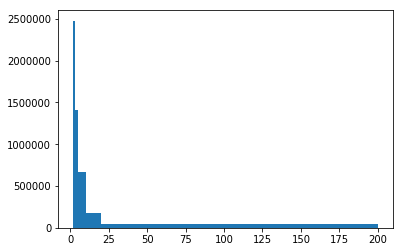

In [23]:
comm = []
for u in two_path.keys():
    tmp = [x[1] for x in two_path[u].items()]
    comm.extend(tmp)
plt.hist(comm, [2, 3, 5, 10, 20, 200])

# prepare for DISGCN

In [14]:
first_item_idx, first_item_f, first_user_item = [], [], []
idx = 0
for u in train_dict:
    for i in train_dict[u]:
        first_user_item.append([u, i])
        for f in two_u[u][i]:
            if f != u:
                first_item_f.append([u, i, f])
                first_item_idx.append(idx)
        idx += 1
first_item_idx, first_item_f, first_user_item = \
np.array(first_item_idx), np.array(first_item_f), np.array(first_user_item)

In [15]:
second_item_idx, second_item_f, second_user_item = [], [], []
idx = 0
for u in candidate_item:
    for i in candidate_item[u]:
        if i not in train_dict[u] and two_path[u][i] >= 5:
            second_user_item.append([u, i])
            for f in two_u[u][i]:
                if f != u:
                    second_item_f.append([u, i, f])
                    second_item_idx.append(idx)
            idx += 1
second_item_idx, second_item_f, second_user_item = \
np.array(second_item_idx), np.array(second_item_f), np.array(second_user_item)

In [16]:
print(first_user_item.shape, second_user_item.shape)

((587360, 2), (833472, 2))


In [20]:
np.savez('../data/{}/first_item.npz'.format(data_name), first_item_idx=first_item_idx, \
         first_item_f=first_item_f, first_user_item=first_user_item)
np.savez('../data/{}/second_item.npz'.format(data_name), second_item_idx=second_item_idx, \
         second_item_f=second_item_f, second_user_item=second_user_item)

In [17]:
first_friend_idx, first_friend_i, first_user_friend= [], [], []
idx = 0
for u in friend_dict:
    for f in friend_dict[u]:
        first_user_friend.append([u, f])
        for i in two_i[u][f]:
            first_friend_i.append([u, f, i])
            first_friend_idx.append(idx)
        idx += 1
first_friend_idx, first_friend_i, first_user_friend = \
np.array(first_friend_idx), np.array(first_friend_i), np.array(first_user_friend)

In [18]:
second_friend_idx, second_friend_i, second_user_friend= [], [], []
idx = 0
for u in candidate_user:
    for f in candidate_user[u]:
        if f not in friend_dict[u] and two_path_iu[u][f] >= 5:
            second_user_friend.append([u, f])
            for i in two_i[u][f]:
                second_friend_i.append([u, f, i])
                second_friend_idx.append(idx)
            idx += 1
second_friend_idx, second_friend_i, second_user_friend = \
np.array(second_friend_idx), np.array(second_friend_i), np.array(second_user_friend)

In [19]:
print(first_user_friend.shape, second_user_friend.shape)

((531066, 2), (598913, 2))


In [21]:
np.savez('../data/{}/first_friend.npz'.format(data_name), first_friend_idx=first_friend_idx, \
         first_friend_i=first_friend_i, first_user_friend=first_user_friend)
np.savez('../data/{}/second_friend.npz'.format(data_name), second_friend_idx=second_friend_idx, \
         second_friend_i=second_friend_i, second_user_friend=second_user_friend)

In [88]:
np.mean([[1, 2, 3], [2, 3, 4], [4, 5, 6]], 0)

array([2.33333333, 3.33333333, 4.33333333])

# sample

In [3]:
def sample_neg(num_neg, num_all, cond_sets):
    tmp = []
    for _ in range(num_neg):
        j = np.random.randint(num_all)
        while True:
            if j not in cond_sets:
                break
            j = np.random.randint(num_all)
        tmp.append([j])
    return tmp

# def sample_dis(nu, cond_sets, nfi, num_all, mup, mdown):
#     num_negatives = 2
#     item_up, item_down, tmp = [], [], []
#     nu_keys, nu_values = nu[0], nu[1]
#     cand_up = nu_keys[nu_values>=nfi+mup]
#     cand_down = nu_keys[nu_values<=nfi-mdown]
#     for j in cand_up:
#         if len(item_up)>=num_negatives:
#             break
#         cond = True
#         for cond_set in cond_sets:
#             cond = cond and j not in cond_set
#         if cond and len(item_up)<num_negatives:
#             item_up.append([j])
#     for j in cand_down:
#         if len(item_down)>=num_negatives:
#             break
#         cond = True
#         for cond_set in cond_sets:
#             cond = cond and j not in cond_set
#         if cond and len(item_down)<num_negatives:
#             item_down.append([j])
#     n_up, n_down = len(item_up), len(item_down)
# #     t = time()
#     tmp = item_up + sample_neg(num_negatives-n_up, num_all, cond_sets)\
#         + item_down + sample_neg(num_negatives-n_down, num_all, cond_sets)
# #     print('add {}s'.format(time()-t))
#     return (tmp, n_up, n_down)

In [9]:
num_items = 30621
num_negative = 10
negative_data, result = [], []
pool = Pool(8)
t = time()
for u, i in positive_data:
    negative_data.append(sample_neg(num_negative, num_items, train_dict[u]))
#     result.append(pool.apply_async(sample_neg, (num_negative, num_items, train_dict[u])))
# pool.close()
# pool.join()
# for idx, res in enumerate(result):
#     tmp = res.get()
#     negative_data.append(tmp)

print('{:.1f}s'.format(time()-t))

34.8s


In [10]:
print(negative_data[2738], '\n', negative_data[12])

[[15977], [8080], [824], [24462], [7091], [4157], [29060], [15078], [25496], [630]] 
 [[21903], [21876], [16981], [15554], [19085], [12610], [5406], [1533], [20662], [20084]]


In [11]:
print(negative_data[2738], '\n', negative_data[12])

[[8982], [4176], [28998], [24930], [6750], [21876], [16178], [15297], [56], [24368]] 
 [[21903], [21876], [16981], [15554], [19085], [12610], [5406], [1533], [20662], [20084]]


In [10]:
num_items, num_negatives = 18995, 10
negative_data = []
num_friend_interaction = np.load('../data/{}/num_friend_interaction.npy'.format(data_name)).item()
pos_mask, neg_mask = np.zeros([len(positive_data), num_negatives]), np.zeros([len(positive_data), num_negatives])
pool_p, pool_n = Pool(8), Pool(8)
result_p, result_n = [], []
record_pn = []
t = time()
for idx, (u, i) in enumerate(positive_data):
    nu = num_friend_interaction[u]
    friend_buy = nu[0][nu[1] > 0]
    friend_notbuy = nu[0][nu[1] == 0]
    if i in friend_buy:
        result_p.append(pool_p.apply_async(sample_neg, (num_negatives, num_items, [train_dict[u], friend_buy])))
#         tmp = sample_neg(num_negatives, num_items, [user_consumed_items[u], friend_buy])
        pos_mask[idx] = np.ones(num_negatives)
        record_pn.append(1)
    else:
        result_n.append(pool_n.apply_async(sample_neg, (num_negatives, num_items, [train_dict[u], friend_notbuy])))
#         tmp = sample_neg(num_negatives, num_items, [user_consumed_items[u], friend_notbuy])
        neg_mask[idx] = np.ones(num_negatives)
        record_pn.append(0)
pool_p.close()
pool_p.join()
pool_n.close()
pool_n.join()
for r in record_pn:
    if r == 1:
        tmp = result_p.pop().get()
    else:
        tmp = result_n.pop().get()
    negative_data.append(tmp)
print('sample pos: {}, neg: {}'.format(np.sum(pos_mask[:, 0]), np.sum(neg_mask[:, 0])))
print('{:.1f}s'.format(time()-t))

sample pos: 220688.0, neg: 366672.0
149.5s


(array([199811.,  23778., 363771.]),
 array([0, 1, 2, 3]),
 <a list of 3 Patch objects>)

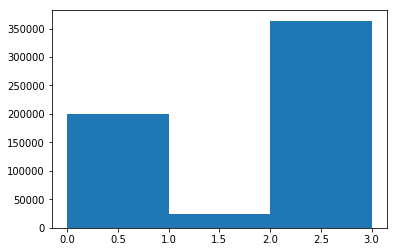

In [61]:
plt.hist(up_list, [0, 1, 2, 3])

(array([493527.,      0.,  93833.]),
 array([0, 1, 2, 3]),
 <a list of 3 Patch objects>)

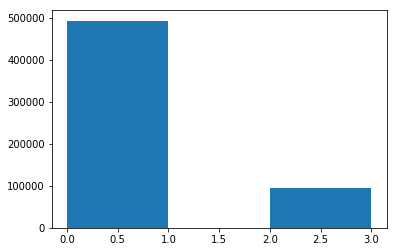

In [22]:
plt.hist(down_list, [0, 1, 2, 3])

In [28]:
0.6*(0.9**7)

0.28697814000000005